In [68]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline


In [220]:
def parse_tb_logs(nb_folds, metrics_path, metrics_to_plot):
    values = defaultdict(list)

    for fold_nb in range(nb_folds):
        fold_string = f"fold_{fold_nb}"
        print(fold_string,  end = ' ')
        event_acc = EventAccumulator(join(metrics_path, fold_string))
        event_acc.Reload()
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"warning: {tag} not in logs")
                pass
        print()
    return values

def interpolate_values(metrics_to_plot, values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        x = np.linspace(0, max(max(values[f'{metric_name}_step'])), num=tot_num_values)
        temp_lists=[]
        for steps, vals in zip(values[f'{metric_name}_step'], values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label):
    for i, metric_name in enumerate(metrics_to_plot):
        epochs = interp_values_df[f'{metric_name}_interp_steps'] 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("epoch")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(100), '--k', linewidth=1, alpha=0.3)
        
    return ax

def plot_agg_metrics(metrics_to_plot, metrics_paths, checkpoints, nb_fold, name: str=None):
    f,a = plt.subplots(len(metrics_to_plot),1)
    f.set_size_inches(6,10)
    f.tight_layout()
    plt.ylim(0,1.1)
    if not type(nb_fold)==list:
        nb_fold = [nb_fold]*len(checkpoints)
        
    for metrics_path, ckpt_name, n_fold in zip(metrics_paths, checkpoints, nb_fold):
        print(ckpt_name)
        metric_values = parse_tb_logs(n_fold, metrics_path, metrics_to_plot)
        interp_values = interpolate_values(metrics_to_plot, metric_values, tot_num_values=100)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)][4]
        print(ckpt_name[label_pos+1:])
        plot_metrics(metrics_to_plot, interp_values_df, a, label=str(ckpt_name[label_pos+1:]))
    for ax in a:
        ax.legend()
        
    f.subplots_adjust(hspace=0.4)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)

In [221]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

metrics_to_plot = ['val_loss', 'val_acc']
nb_fold= 3


In [225]:
checkpoints_d3 = ['ckpt_27096585_0704_1437_synth_rand_b0_d3',
                'ckpt_27096592_0704_1527_synth_um_b1_d3',
                'ckpt_27097384_0704_1712_synth_um_b10_d3',
                'ckpt_27096591_0704_1527_synth_um_b100_d3']

checkpoints_d4 = ['ckpt_27096594_0704_1539_synth_rand_b0_d4',
                  'ckpt_27096593_0704_1538_synth_um_b1_d4',
                  'ckpt_27097385_0704_1740_synth_um_b10_d4',
                  'ckpt_27098061_0704_2056_synth_um_b100_d4',
                  'ckpt_27098062_0704_2057_synth_um_b1000_d4']

checkpoints_d5 = ['ckpt_27098065_0704_2133_synth_rand_b0_d5']


checkpoints_b1 = ['ckpt_27096592_0704_1527_synth_um_b1_d3',
              'ckpt_27096593_0704_1538_synth_um_b1_d4']

checkpoints_b10 = ['ckpt_27097384_0704_1712_synth_um_b10_d3',
              'ckpt_27097385_0704_1740_synth_um_b10_d4']

checkpoints_b100 = ['ckpt_27096591_0704_1527_synth_um_b100_d3',
                  'ckpt_27098061_0704_2056_synth_um_b100_d4']

#checkpoints_b1000 = ['ckpt_27098062_0704_2057_synth_um_b1000_d4']

In [226]:
checkpoints_list = [checkpoints_d3, checkpoints_d4, checkpoints_d5, 
               checkpoints_b1, checkpoints_b10, checkpoints_b100]

ckpt_names = ['checkpoints_d3', 'checkpoints_d4', 'checkpoints_d5',
              'checkpoints_b1', 'checkpoints_b10', 'checkpoints_b100']


ckpt_27096585_0704_1437_synth_rand_b0_d3
fold_0 val_loss 180, val_acc 180, 
fold_1 val_loss 180, val_acc 180, 
fold_2 val_loss 180, val_acc 180, 
rand_b0_d3
ckpt_27096592_0704_1527_synth_um_b1_d3
fold_0 val_loss 19, val_acc 19, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 17, val_acc 17, 
um_b1_d3
ckpt_27097384_0704_1712_synth_um_b10_d3
fold_0 val_loss 19, val_acc 19, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 19, val_acc 19, 
um_b10_d3
ckpt_27096591_0704_1527_synth_um_b100_d3
fold_0 val_loss 18, val_acc 18, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 19, val_acc 19, 
um_b100_d3


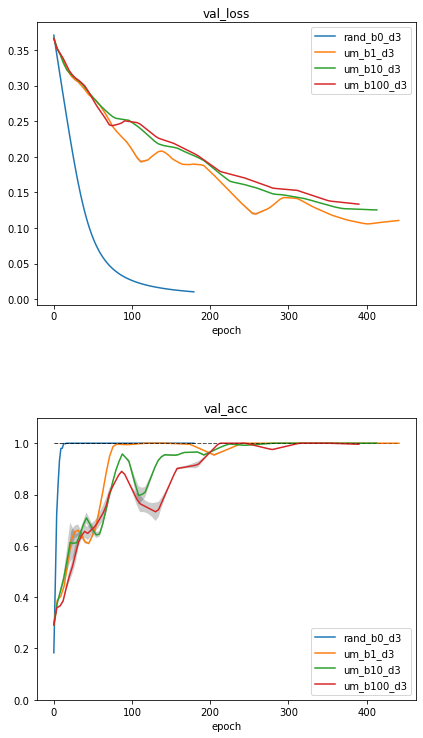

ckpt_27096594_0704_1539_synth_rand_b0_d4
fold_0 val_loss 300, val_acc 300, 
fold_1 val_loss 300, val_acc 300, 
fold_2 val_loss 300, val_acc 300, 
rand_b0_d4
ckpt_27096593_0704_1538_synth_um_b1_d4
fold_0 val_loss 19, val_acc 19, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 19, val_acc 19, 
um_b1_d4
ckpt_27097385_0704_1740_synth_um_b10_d4
fold_0 val_loss 27, val_acc 27, 
fold_1 val_loss 27, val_acc 27, 
fold_2 val_loss 26, val_acc 26, 
um_b10_d4
ckpt_27098061_0704_2056_synth_um_b100_d4
fold_0 val_loss 27, val_acc 27, 
fold_1 val_loss 27, val_acc 27, 
fold_2 val_loss 27, val_acc 27, 
um_b100_d4
ckpt_27098062_0704_2057_synth_um_b1000_d4
fold_0 val_loss 27, val_acc 27, 
fold_1 val_loss 27, val_acc 27, 
fold_2 val_loss 27, val_acc 27, 
um_b1000_d4


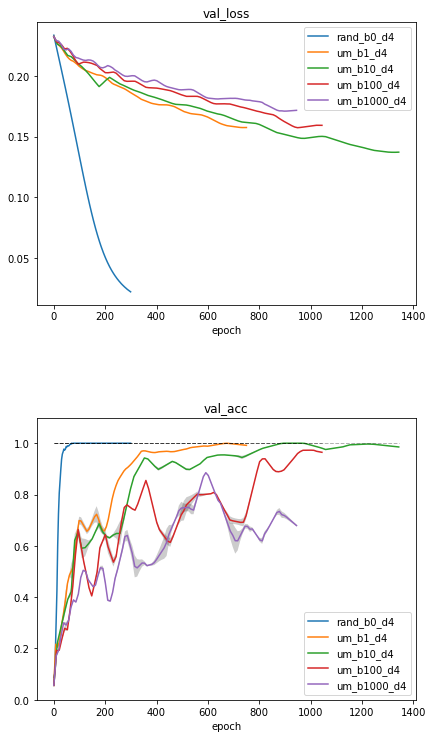

ckpt_27098065_0704_2133_synth_rand_b0_d5
fold_0 val_loss 600, val_acc 600, 
fold_1 val_loss 600, val_acc 600, 
fold_2 val_loss 600, val_acc 600, 
rand_b0_d5


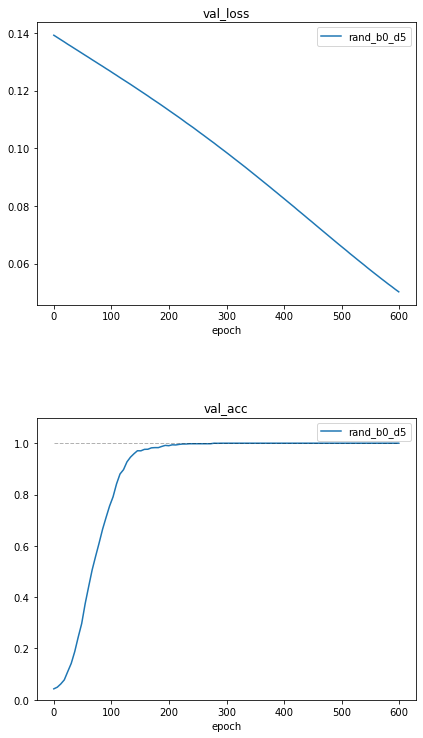

ckpt_27096592_0704_1527_synth_um_b1_d3
fold_0 val_loss 19, val_acc 19, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 17, val_acc 17, 
um_b1_d3
ckpt_27096593_0704_1538_synth_um_b1_d4
fold_0 val_loss 19, val_acc 19, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 19, val_acc 19, 
um_b1_d4


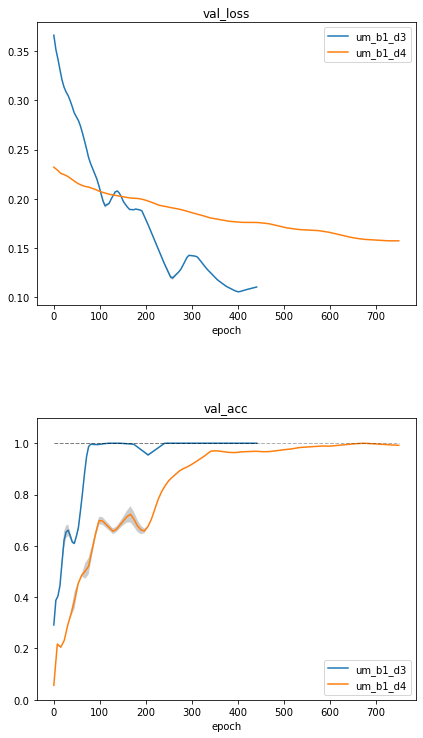

ckpt_27097384_0704_1712_synth_um_b10_d3
fold_0 val_loss 19, val_acc 19, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 19, val_acc 19, 
um_b10_d3
ckpt_27097385_0704_1740_synth_um_b10_d4
fold_0 val_loss 27, val_acc 27, 
fold_1 val_loss 27, val_acc 27, 
fold_2 val_loss 26, val_acc 26, 
um_b10_d4


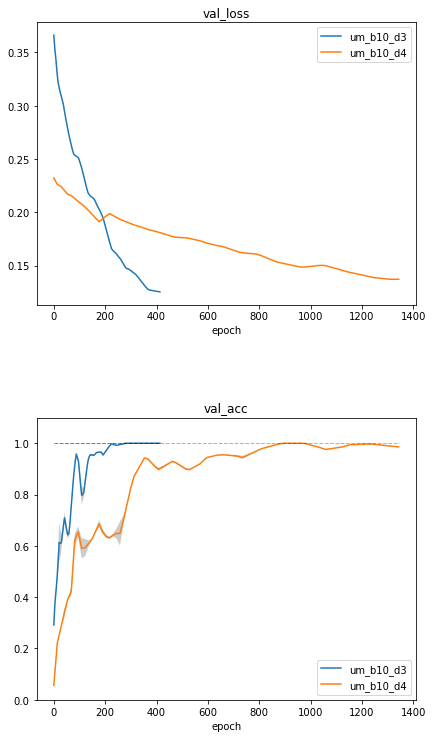

ckpt_27096591_0704_1527_synth_um_b100_d3
fold_0 val_loss 18, val_acc 18, 
fold_1 val_loss 19, val_acc 19, 
fold_2 val_loss 19, val_acc 19, 
um_b100_d3
ckpt_27098061_0704_2056_synth_um_b100_d4
fold_0 val_loss 27, val_acc 27, 
fold_1 val_loss 27, val_acc 27, 
fold_2 val_loss 27, val_acc 27, 
um_b100_d4


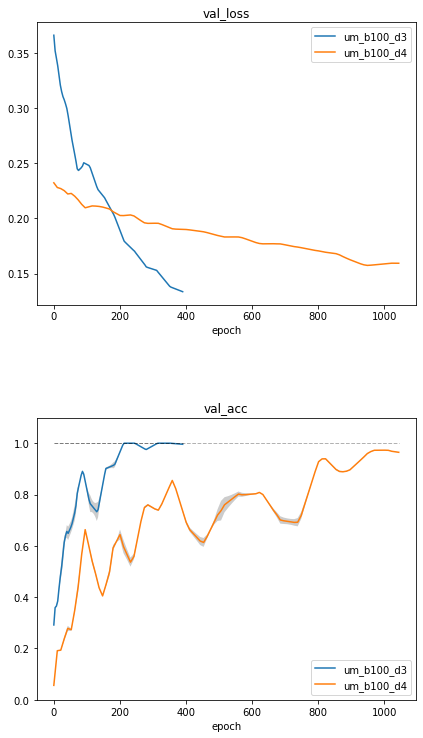

In [227]:
for checkpoints, ckpt_name in zip(checkpoints_list, ckpt_names):
    metrics_paths = [f"../logs/{ckpt}/metrics_synth/" for ckpt in checkpoints]
    plot_agg_metrics(metrics_to_plot, 
                     metrics_paths, checkpoints, nb_fold, 
                     name=ckpt_name)
    plt.show()